# Parte 2: DCCaracteres

Luego de permanecer tanto tiempo trabajando en la salud, te das cuenta de que un problema serio es
que nadie puede entender la letra de las/os doctores. Inspirado por tu reciente éxito en la prediccion de
la diabetes, decides usar tus habilidades en SVM para crear un sistema capaz de interpretar la jeroglífica
letra de estos profesionales.

In [37]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv('../caracteres.csv', sep=',', index_col=0)

## Actividad 1: Análisis preliminar de los datos 

- 2.1 Verifica cuales son las diferentes categorías que existen y el balance entre estas. 

In [25]:
# Cuáles y cuántas son las categorías existentes 
print(df['label'].unique())
print(df['label'].nunique())

# Veremos la cantidad de datos que hay por cada label
cantidades = {}
for i in df['label'].unique():
    cantidades[i] = df['label'].loc[df['label'] == i].count()

# imprimiremos el valor con más datos y el valor con menos datos
print('minimo:', min(cantidades.values()))
print('maximo:', max(cantidades.values()))

['F' '4' 'Q' 'W' 'K' '1' 'D' 'O' 'C' '5' 'H' '3' 'E' 'J' 'T' 'P' 'Z' 'S'
 'N' 'M' 'Y' '9' 'U' 'V' 'G' '7' '2' '8' 'A' '6' 'R' 'X' 'B' 'I' '0' 'L']
36
minimo: 2407
maximo: 2418


Hay 36 categorías diferentes, cada una tiene entre 2407 y 2418 datos, lo que indica que los datos son muy homogéneos y las categorías tienen todas una cantidad de datos muy similar para entrenar el SVM.

- 2.2 Indica las ventajas de que balancear el número de instancias entre categorías para este problema en particular. Considere en su respuesta el desempeño en producción (cuando prediga datos reales) de un modelo entrenado con datos no balanceados.

Es importante balancear los datos para que no existan *biases* en el modelo entrenado. Se requiere la mayor cantidad de datos posibles en cada categoría para poder hacer el área de clasificación de cada una. Si se entrenara una SVM con datos imbalanceados habrían tendencias a la hora de predecir. Por ejemplo, si entrenamos ua SVM y usamos una categoría A con más datos que la categoría B, se tendrán más ejemplos para A, entonces su espacio será más grande que el de B (el algoritmo tendrá una tendencia hacia clasificar en A, porque no aprendió lo suficiente acerca de B). En este caso, si intentamos clasificar un dato de la clase B, este podría terminar siendo clasificado como A, porque el margen de decisión quedará corrido para un lado tal que sea más probable clasificar en A.

- 2.3 Lee el siguiente artículo, que aborda el problema de conjuntos de datos imbalanceados: https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data y explica brevemente las dos estrategias mencionadas para lidiar el desbalance en los conjuntos de datos.


**Submuestreo:** Reducir la cantidad de datos de la clase con más datos. Por ejemplo, si se tienen dos clases, A y B: A con 3 datos y B con 300 datos. En este caso se tiene un desequilibrio tal que A tiene aproximadamente el 1% de los datos mientras B tiene el otro 99%. el **submuestreo** busca reducir la cantidad de datos de B tal que (por ejemplo) se utilicen 30 en lugar de 300, así queda un desequilibrio mucho menor, y así A compone al 9% de los datos. Esta reducción es hecha **mediante un factor de 10**.

**Aumento de peso:** Es un peso que se aplica a la clase que fue reducida (con **submuestreo**) de esta forma no se afecta la proporción real de las clases (si los datos realmente existen en una razón de 1:100, al submuestrear cambia la razón). Para devolver la razón original de los datos, **se aplica un peso igual al factor de reducción** de muestreo (en el caso anterior 10)

## Actividad 2: Preprocesamiento

- Separa el conjunto de datos entre variables dependientes e independientes

In [26]:
y = df["label"]
X = df.loc[:, df.columns != "label"]

- Realiza un escalamiento de los datos. Justifica la importancia de escalar los datos antes de entrenar modelos como SVM. 


Se escalan los datos para trabajar con dimensiones similares dentro del espacio. Esto es muy importante ya que en el caso de usar distintas métricas o tipos de datos estos pueden afectar la distancia entre dos puntos del espacio de deción. Si trabajo con varios datos y tengo (por ejemplo) una columna con valores que van entre 0 y 1, y otra con valores entre 0 y 255. El espacio debe ser escalado porque en una columna un cambio de 0.9 representa un gran cambio, perola otra columna 0.9 representa un cambio muy pequeño. La idea es escalarlo para que la magnitud de los cambios sea similar en cada uno de los atributos.

En este caso no se deben escalar los datos ya que todos toman valores entre 0 y 255, entonces los datos originales ya están escalados.

In [44]:
# Escalamiento de atributos
X_scaled = X.to_numpy()

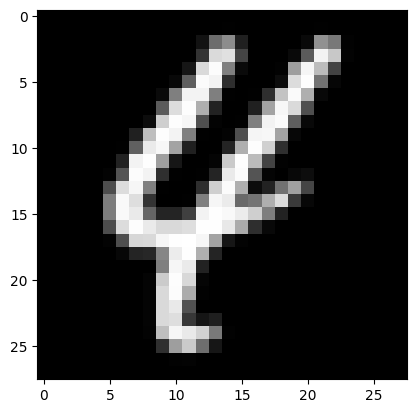

In [47]:
# Puedes usar esta celda para visualizar los caracteres
img_data = X_scaled[1].reshape(28, 28).T
plt.imshow(img_data, cmap="gray")
plt.show()

- Realiza un escalamiento de los datos. Justifica la importancia de escalar los datos antes de entrenar modelos como SVM. Verifica las proporciones de los datos entre categorías para cada subconjunto.


Usaremos un 80% de los datos para entrenar y 20% de los datos para el test (según lo que vimos en clases). Usamos esta proporción porque se debe usar una gran cantidad de datos para entrenar al algoritmo, pero también se requiere una cantidad significativa para poder validar y testearlo, para saber que el entrenamiento que hicimos funciona

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
# vemos el tamaño de nuestros sets
print(f"Tamaño X train {X_train.shape}")
print(f"Tamaño y train {y_train.shape}")
print(f"Tamaño X test  {X_test.shape}")
print(f"Tamaño y test  {y_test.shape}")

# tenemos que ver la proporción de cada letra en cada uno de los sets
proporciones_test = {}
proporciones_train = {}
tamano_train = len(y_train)
tamano_test = len(y_test)
for i in df['label'].unique():
    # la proporción es la cantidad de datos pertenecientes a la clase / cantidad de datos totales
    proporciones_train[i] = y_train.loc[y_train == i].count() / tamano_train
    proporciones_test[i] = y_test.loc[y_test == i].count() / tamano_test

# imprimiremos la proporción más baja y la más alta
print('minima proporcion train:', min(proporciones_train.values()))
print('maxima proporcion train:', max(proporciones_train.values()))

print('minima proporcion test:', min(proporciones_test.values()))
print('maxima proporcion test:', max(proporciones_test.values()))

Tamaño X train (69491, 784)
Tamaño y train (69491,)
Tamaño X test  (17373, 784)
Tamaño y test  (17373,)
minima proporcion train: 0.027010692032061707
maxima proporcion train: 0.028363385186570923
minima proporcion test: 0.02561445921832729
maxima proporcion test: 0.030910032809532032


Todas las clases tienen una proporción similar en ambos sets, al igual que en el set general, se dividieron homogéneamente

## Actividad 3:  Entrenamiento de modelo lineal

- Entrena un modelo lineal que identifique caracteres. Para eso, utiliza el módulo SVC de la librería sklean.svm. Visualiza los resultados de tu modelo mediane una matriz de confusión, e identifica las categorías más confundidas entre sí.

In [57]:
from sklearn import svm

# Modelo con kernel lineal
linear_classifier = svm.SVC(kernel = "linear")

# Entrenamiento
linear_classifier.fit(X_train, y_train)
svm_classifier = linear_classifier

# Predicción
pred1 = svm_classifier.predict(X_test)

In [ ]:
# Matriz de confusión del modelo lineal
from sklearn import metrics

metrics.confusion_matrix(y_test, pred1)

- Calcula el accuracy para el modelo lineal. Obtén además los puntajes de precission, recall y f1-score para cada uno de las categorías del modelo entrenado. Comente sobre el rendimiento del modelo en base a estos resultados y los de la matriz de confusi ́on, y formula una hipótesis que pueda explicar los resultados obtenidos. En tu explicación, se espera que incorpores las métricas solicitadas y demuestres un manejo de su significado.

In [ ]:
# Métricas del modelo lineal
print('accuracy:',metrics.accuracy_score(y_test, pred1))

print('Recall score:', metrics.recall_score(y_test, pred1))
print("Precision score:", metrics.precision_score(y_test, pred1))

## Actividad 4: Entrenamiento de modelo no lineal

- Investiga sobre el kernel RBF. Explica su funcionamiento en términos generales y las ventajas o desventajes que puede tener éste modelo en comparación con un kernel lineal.

- Entrena un modelo no lineal que identifique caracteres. Visualiza los resultados de tu modelo mediane una matriz de confusión, e identifica las categorías más confundidas entre sí.

In [ ]:
# Modelo con kernel no lineal 

# Entrenamiento

# Predicción

- Calcula el accuracy para el modelo no lineal. Obtén además los puntajes de precission, recall y f1-score para cada uno de las categorías del modelo entrenado. Comente sobre el rendimiento del modelo en base a estos resultados y los de la matriz de confusión, y formula una hipótesis que pueda explicar los resultados obtenidos. En tu explicación, se espera que incorpores las métricas solicitadas y demuestres un manejo de su significado.

In [ ]:
# Matriz de confusión del modelo no lineal


In [ ]:
# Métricas del modelo no lineal

## Actividad 5: Optimización del modelo


Investiga los siguientes hiperparámetros que pueden ajustarse para el entrenamiento de SVM:
- C
- Gamma

Detalla en tu respuesta qué hace cada uno de estos, en qué circunstancias pueden especificarse su valor, y cuales son los posibles efectos no deseados de utilizar valores extremos para ámbos hiperparámetros.

- Investiga sobre el m ́etodo de cross validation. Explica brevemente en qu ́e consiste, y cuál es su utilidad en la validación de un modelo entrenado.

- Investiga y explica brevemente en qué consiste la optimización de hiperparámetros en base a Grid Search, e indica el rol de cross validation en este método.


- Ejecuta una optimización en grid search en base al conjunto de hiperparámetros que consideres conveniente. Evalúa el modelo obtenido en el set de testeo, y grafica la matriz de confusión.


In [ ]:
# Iteración de hiperparámetros con Grid Search

In [ ]:
# Matriz de confusión del modelo optimizado

- Reporta el accuracy obtenido, y el precision, recall y f1-score para cada categoría. Compara los resultados con los obtenidos para los otros modelos.


In [ ]:
# Métricas del modelo optimizado

- En base a los resultados obtenidos con el modelo optimizado, comenta brevemente sobre las principales virtudes y limitaciones del SVM en el contexto de visi ́on por computador. En tu respuesta, procura aludir a las categorías con mejor y con peor desempe ̃no bajo las m ́etricas estudiadas. Por último, comenta sobre métodos adicionales a los vistos en esta tarea que podr ́ıan mejorar el rendimiento de SVM en el contexto del reconocimiento de caracteres.